In [11]:
from google.colab import drive
import os
# Mount Google Drive
#drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LEARN/Finance/quantitative finance/Forecasting-stocks')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/LEARN/Finance/quantitative finance/Forecasting-stocks


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2352 entries, 2016-01-04 to 2025-05-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2352 non-null   float64
 1   High    2352 non-null   float64
 2   Low     2352 non-null   float64
 3   Close   2352 non-null   float64
 4   Volume  2352 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 110.2 KB


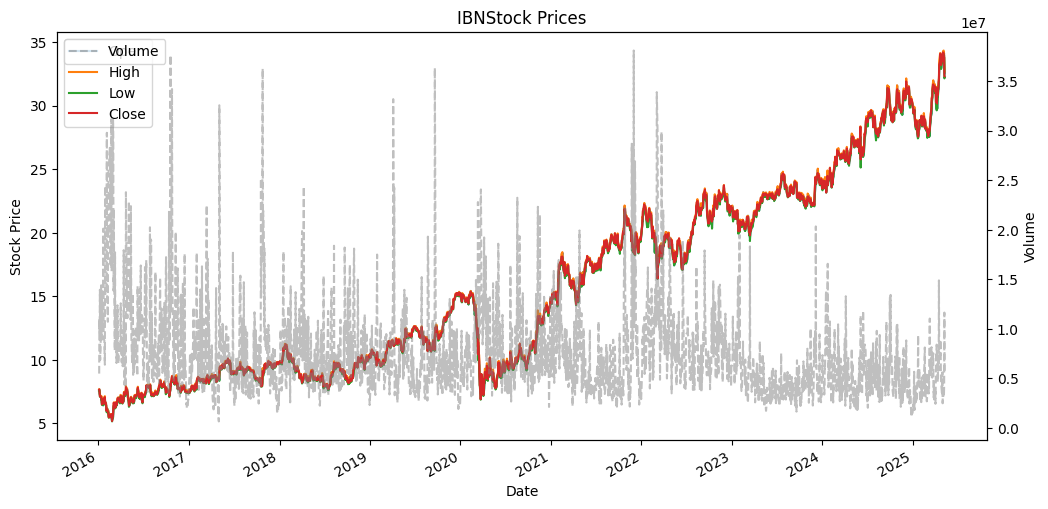

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2352 entries, 2016-01-04 to 2025-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2352 non-null   float64
dtypes: float64(1)
memory usage: 36.8 KB


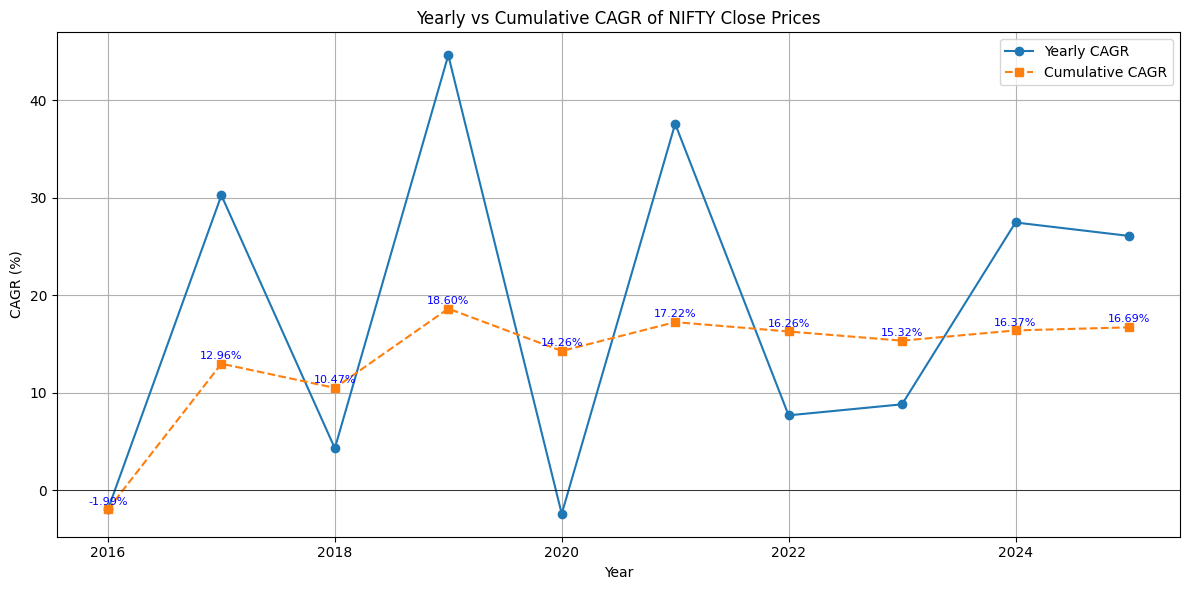

In [12]:
#%run noise_types.ipynb
%run forecast_analysis.ipynb
%run time_series.ipynb
%run ML_algorithms.ipynb
%run bayesian_prior_posterior.ipynb
%run monte_carlo.ipynb
%run stock_option_data.ipynb
%run stock_forecasting.ipynb

predictor = StockPredictor('IBN', '2014-01-01', date.today(), 'Close', nfuture = 252)
predictor.data_initiation()

FORECASTING : MACHINE LEARNING

Daily mu (sigma) = 0.08% ± 2.18%
Annual mu (sigma) = 21.19% ± 34.58%


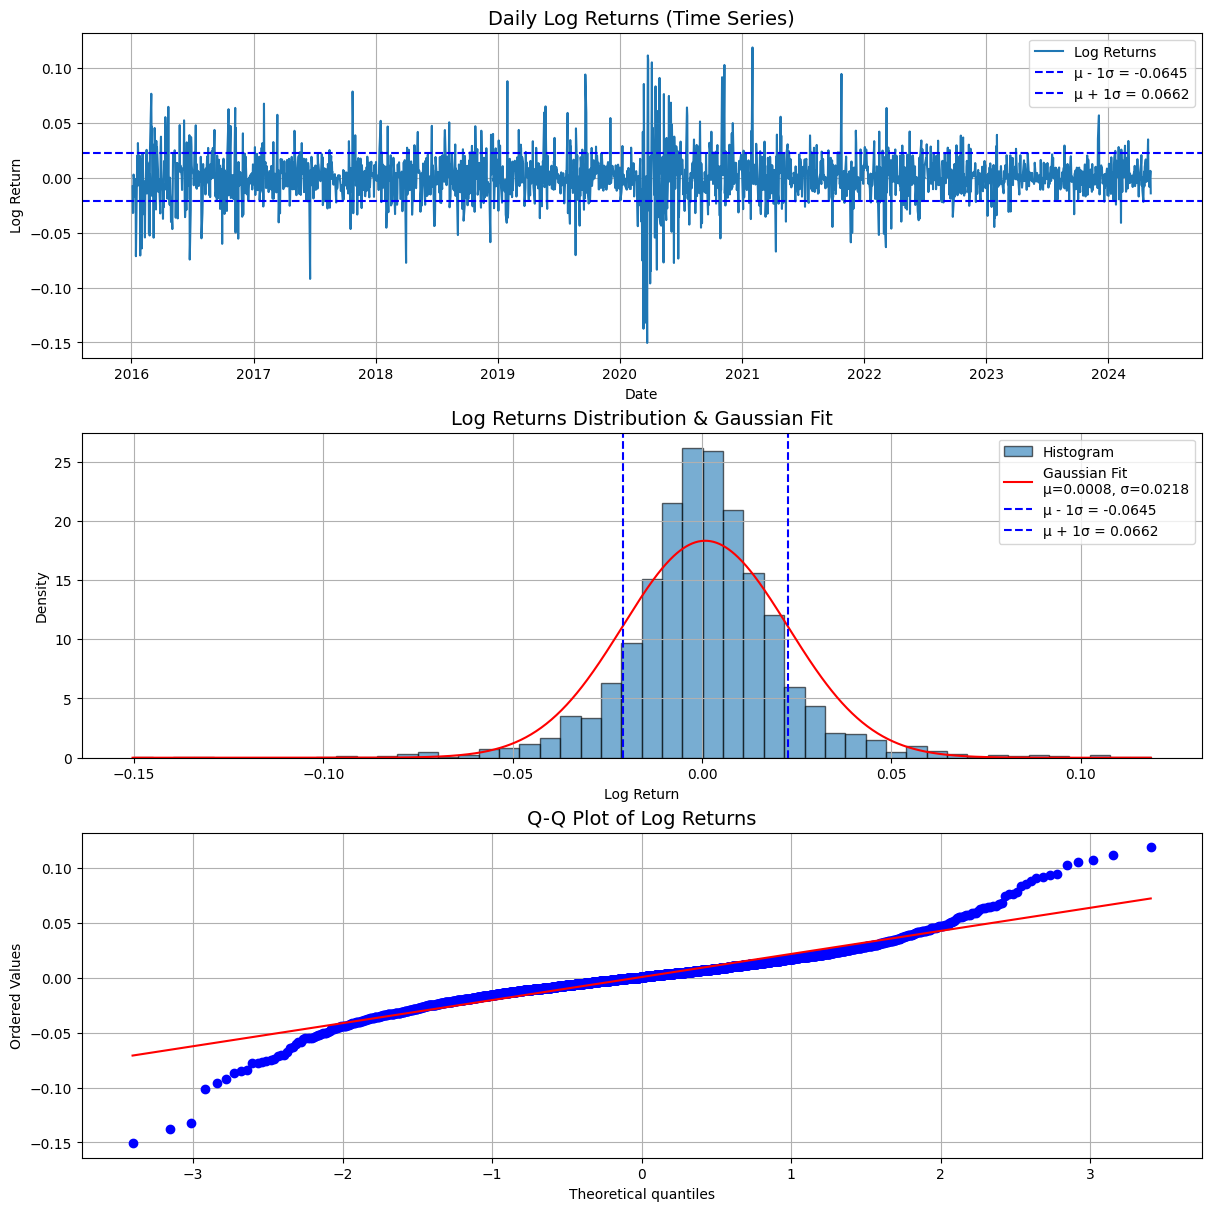

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2342 entries, 2016-01-19 to 2025-05-09
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    2342 non-null   int32  
 1   month   2342 non-null   int32  
 2   day     2342 non-null   int32  
 3   Noise   2342 non-null   float64
 4   lag1    2342 non-null   float64
 5   lag2    2342 non-null   float64
 6   lag3    2342 non-null   float64
 7   lag4    2342 non-null   float64
 8   lag5    2342 non-null   float64
 9   lag6    2342 non-null   float64
 10  lag7    2342 non-null   float64
 11  lag8    2342 non-null   float64
 12  lag9    2342 non-null   float64
 13  lag10   2342 non-null   float64
dtypes: float64(11), int32(3)
memory usage: 247.0 KB
Training Metrics:
  - MSE  = 0.1104
  - RMSE = 0.3322
  - MAE  = 0.2350
  - MAPE = 1.84%
  - R2 score = 1.00%


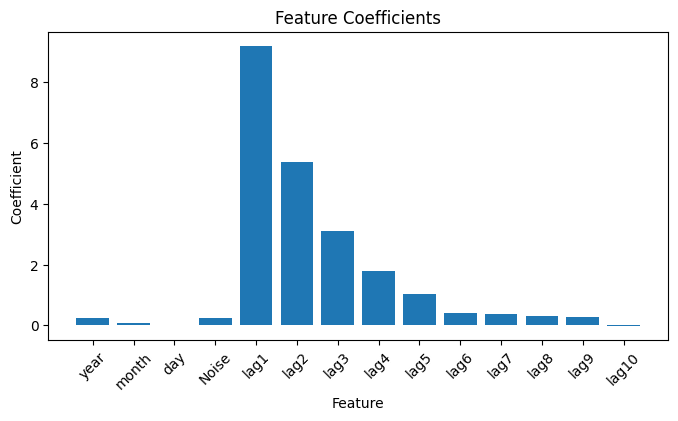

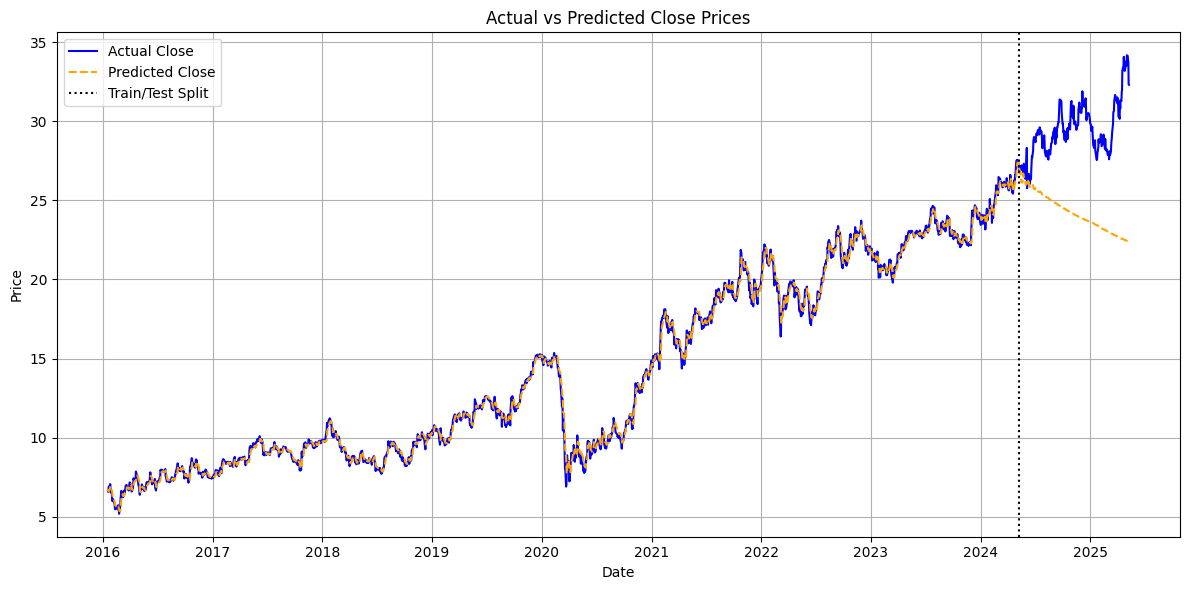

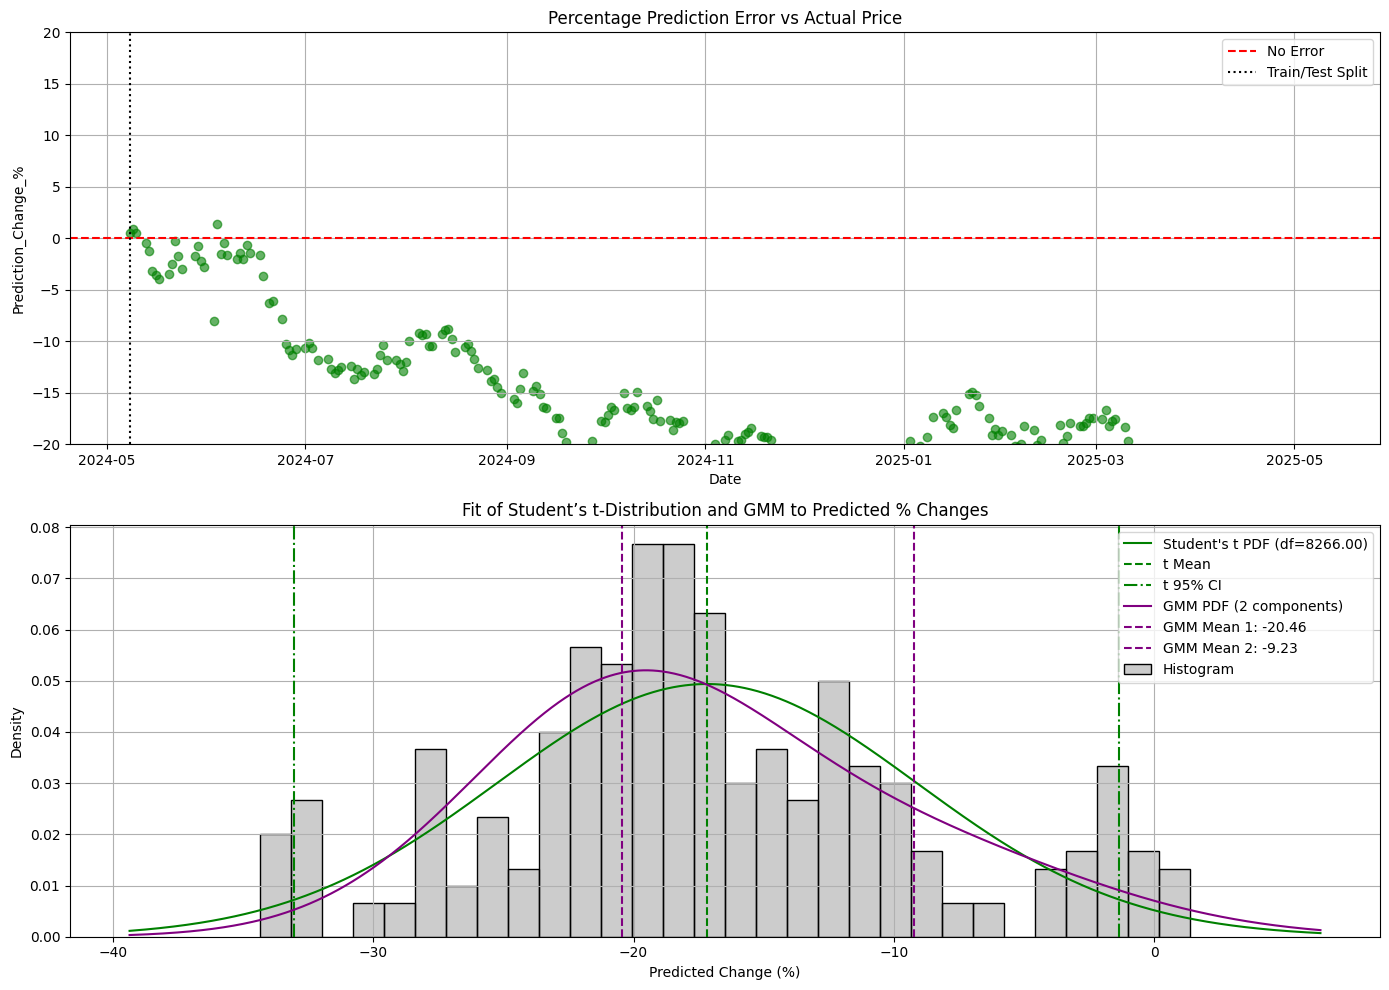

Student's t-distribution 95% CI: [-33.02, -1.34]
GMM means: [-20.46034465  -9.23417785], std devs: [5.99874682 6.8736026 ]


In [13]:
npast = 10 #Memory
predictor.run_ml(npast=npast, model_type='RidgeModel') #Options available - Ridge model , RandomForestModel , SimpleNNModel

FORECASTING : MONTE CARLO

Daily mu (sigma) = 0.08% ± 2.18%
Annual mu (sigma) = 21.19% ± 34.58%


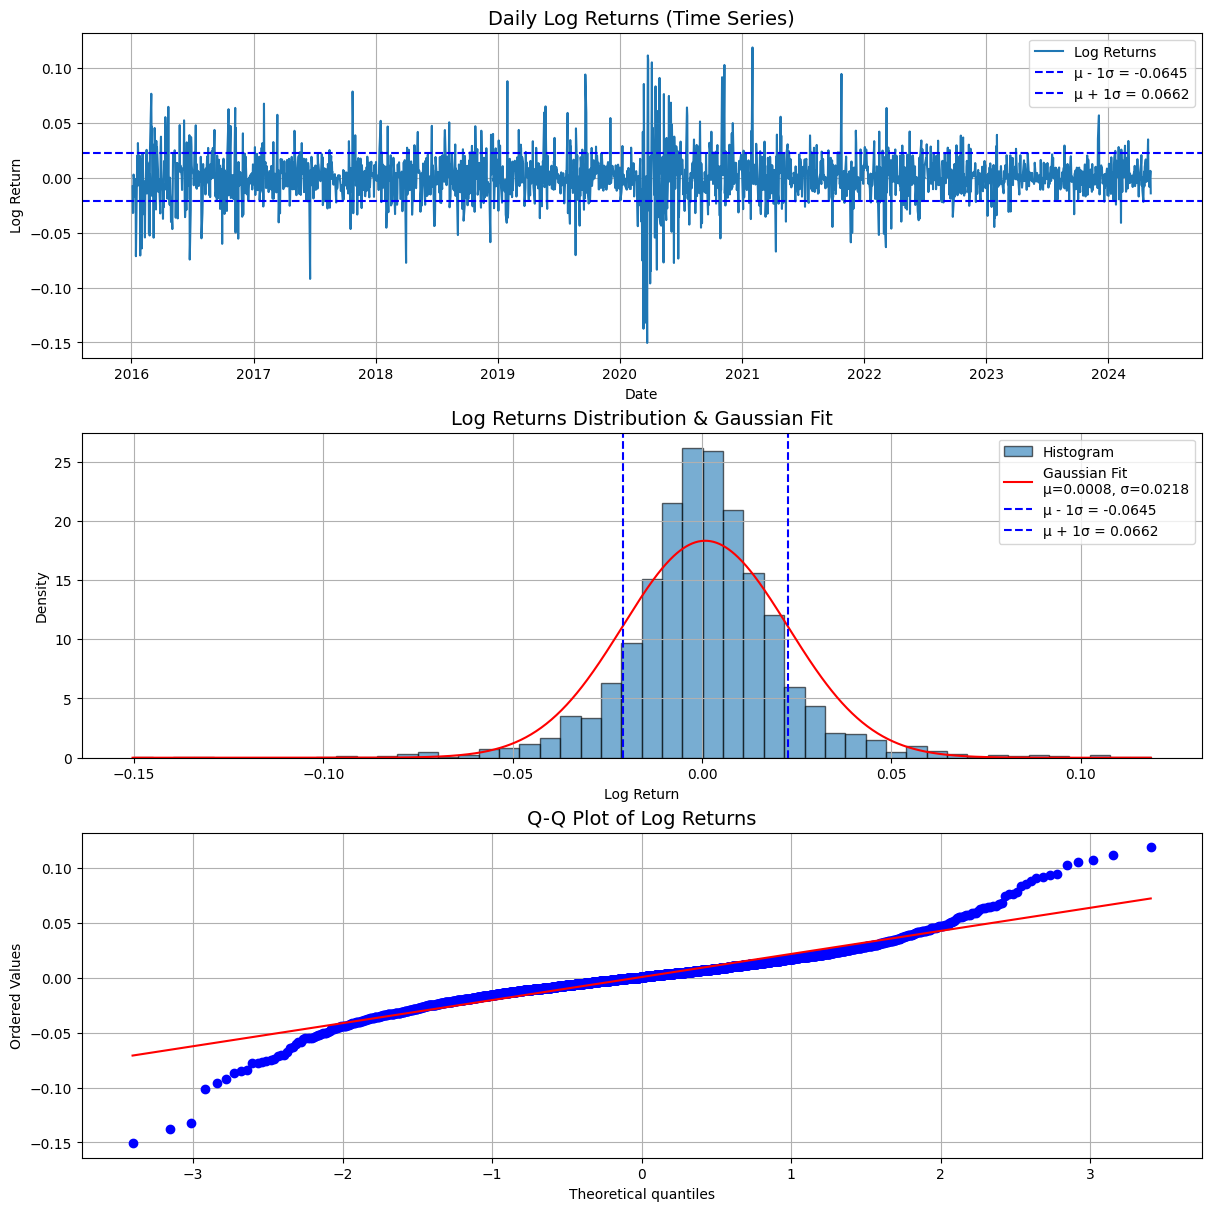

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


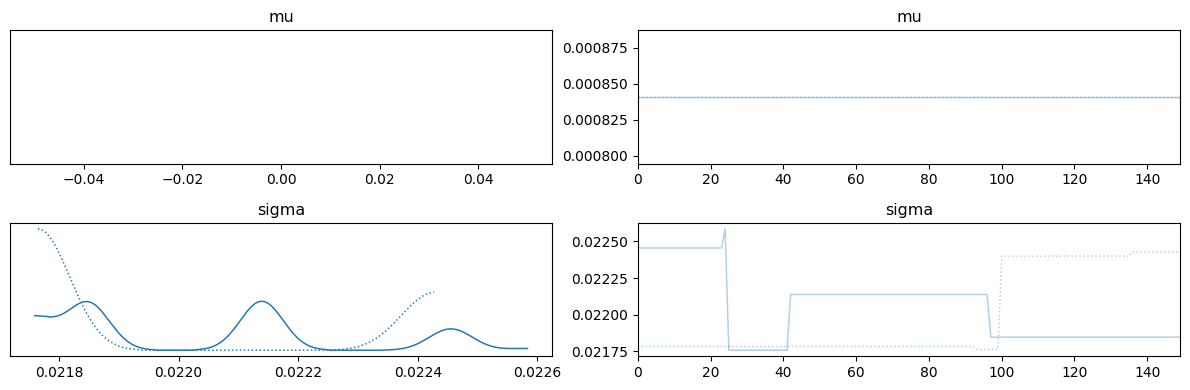

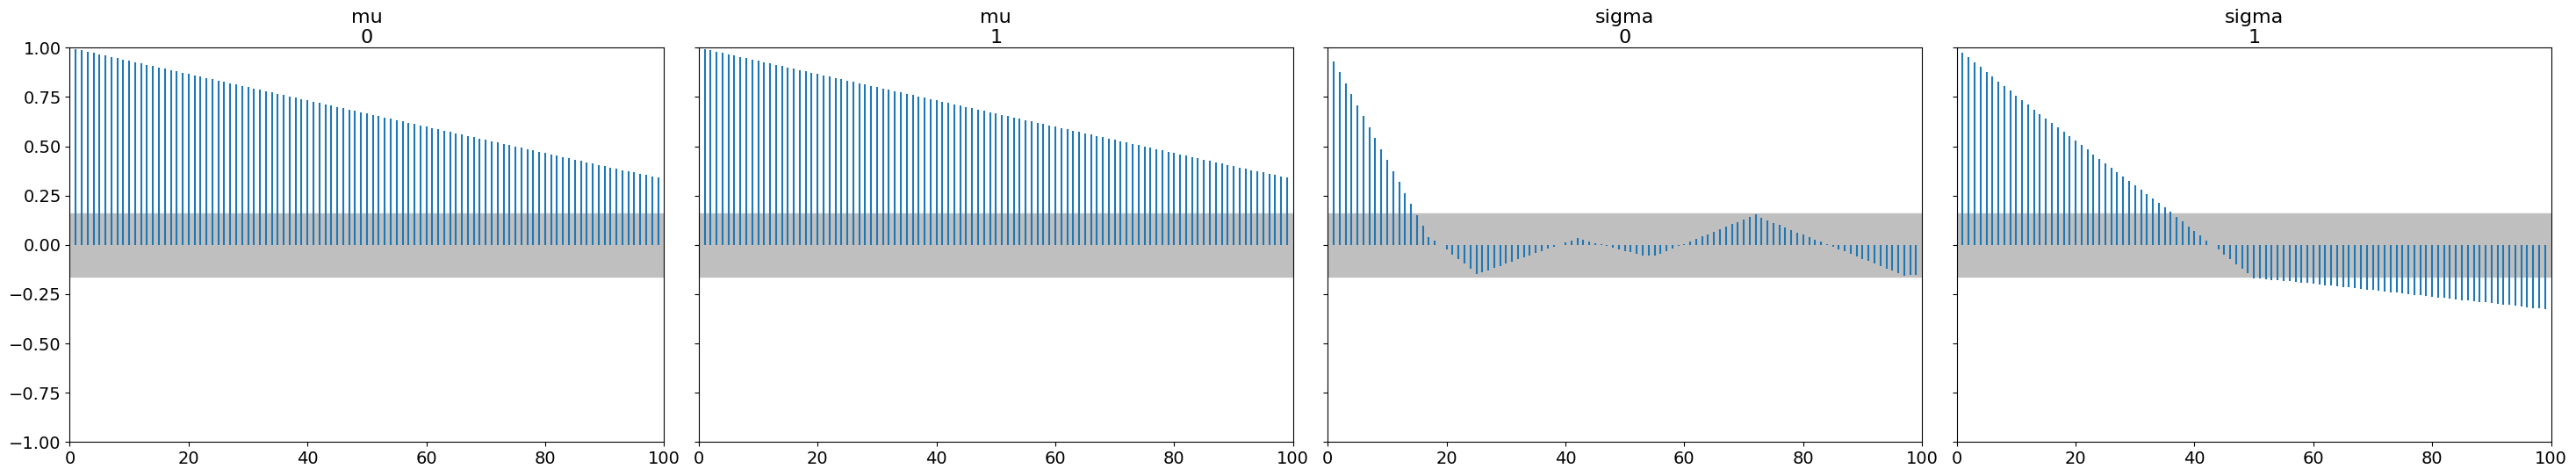

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.0008  0.0000  0.0008   0.0008     0.0000      0.0  300.0000   
sigma  0.0220  0.0003  0.0218   0.0225     0.0001      0.0   11.7539   

       ess_tail   r_hat  
mu     300.0000     NaN  
sigma   18.9352  1.5883  
Today's value =  32.31


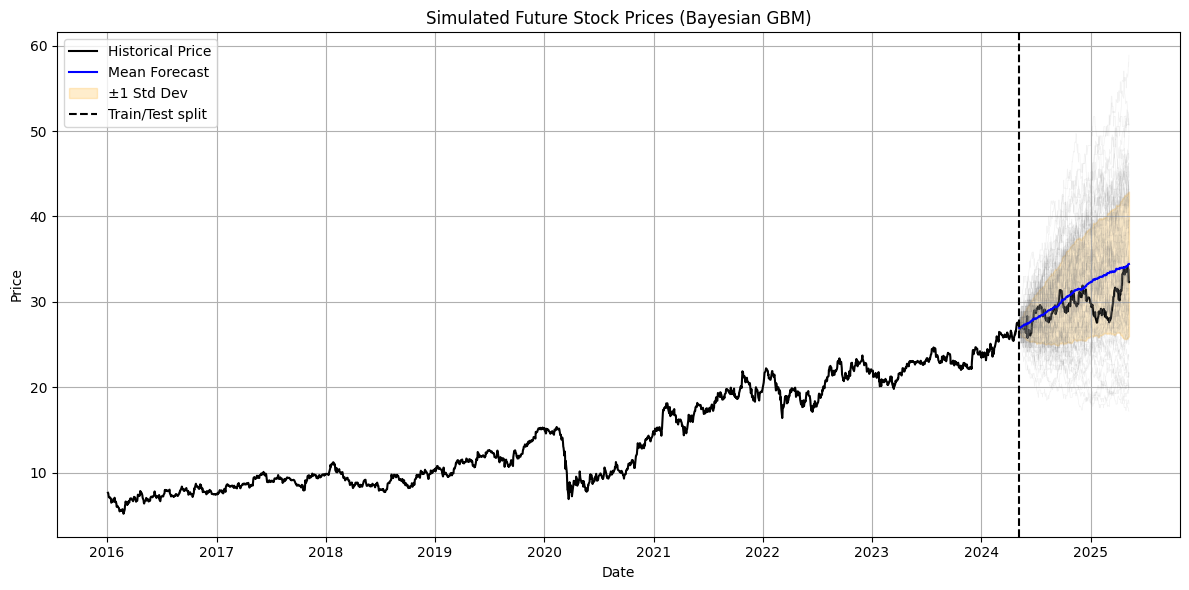

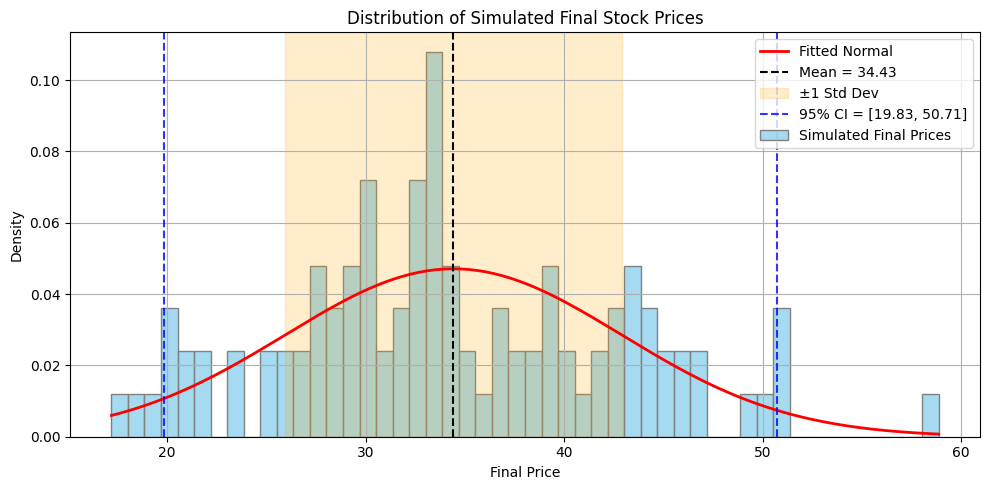

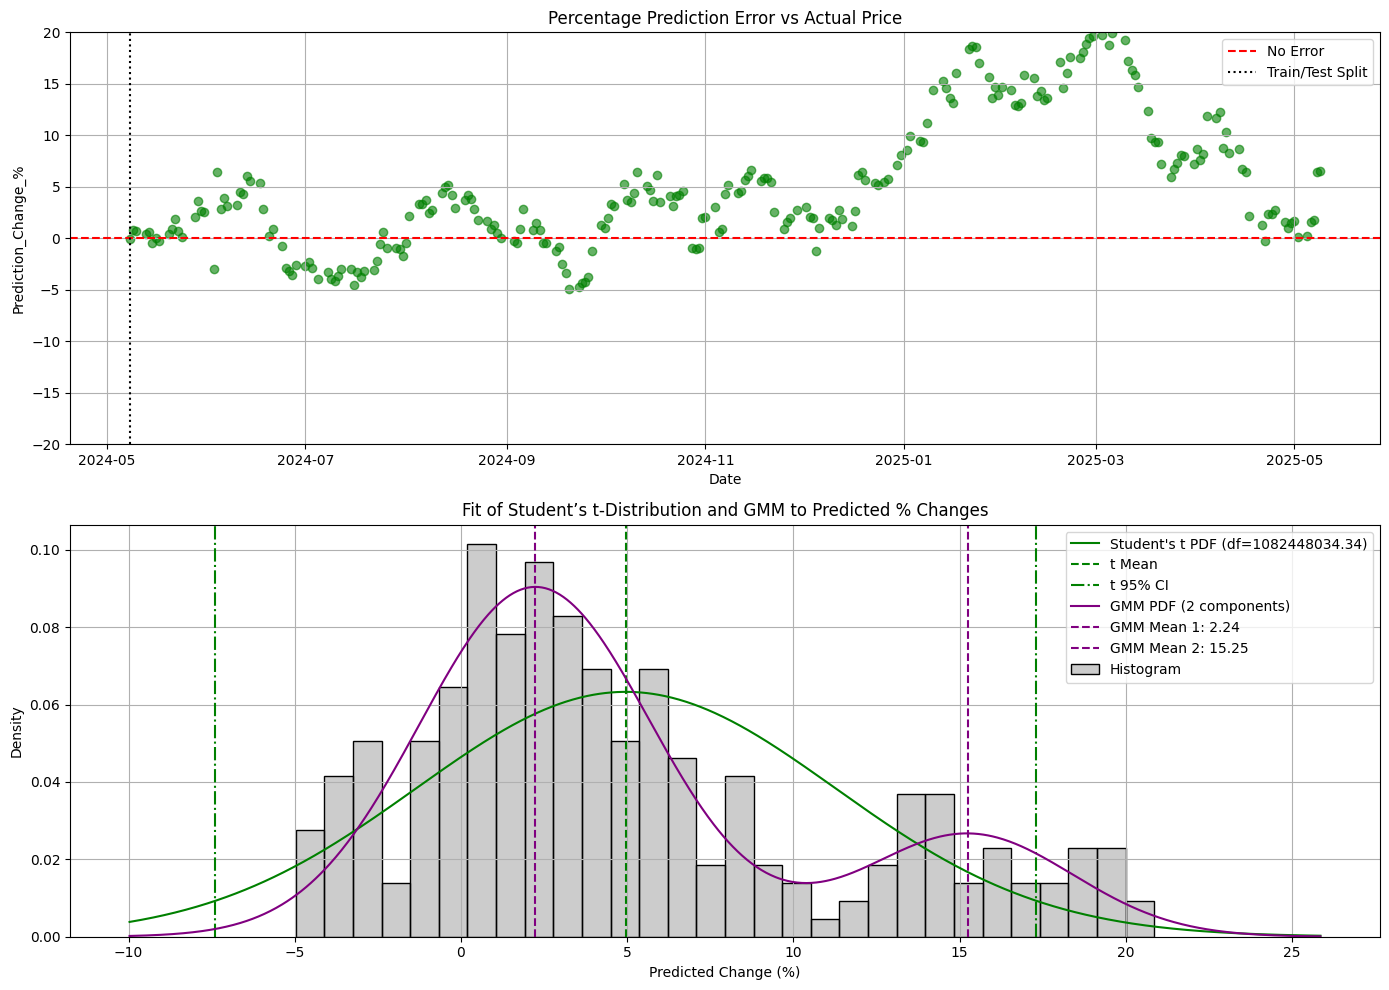

Student's t-distribution 95% CI: [-7.39, 17.31]
GMM means: [ 2.23556279 15.25434263], std devs: [3.48880617 3.13452559]


In [14]:
predictor.run_mcmc(nsample=100, nburn = 50, nchain = 2, model_type='BinomialTree') #Options available - BinomialTree , GBM, Merton

#Uses bayesian posterior of paramas obtained from historical data

FORECASTING : TIME SERIES

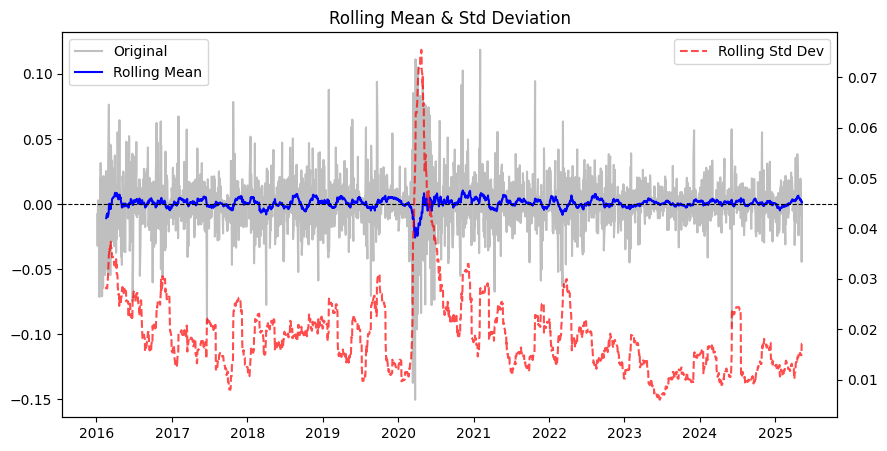

ADF Test
ADF Statistic: -10.3357, p-value: 0.0000
Stationary
KPSS Test
KPSS Statistic: 0.0291, p-value: 0.1000
Stationary


/tmp/ipython-input-12-131444429.py:176: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, crit = kpss(self.series.dropna(), regression='c')


<Figure size 1200x500 with 0 Axes>

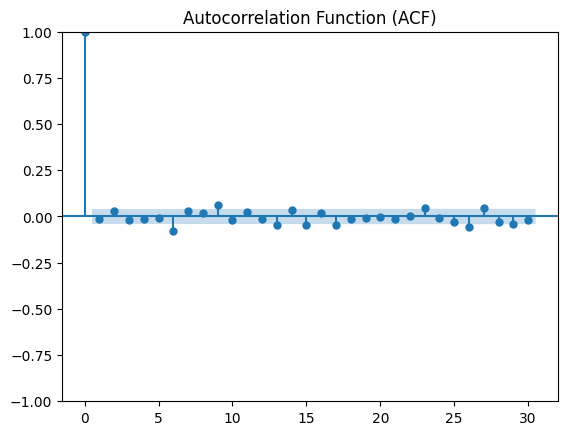

<Figure size 1200x500 with 0 Axes>

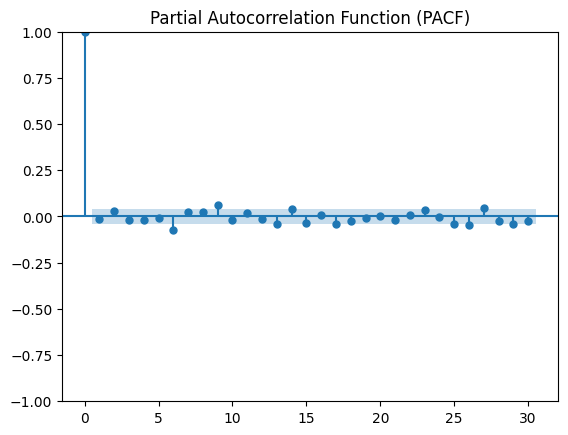

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 2099
Model:             SARIMAX(10, 0, 0)x(1, 0, 0, 12)   Log Likelihood                5069.777
Date:                             Tue, 24 Jun 2025   AIC                         -10115.554
Time:                                     08:28:12   BIC                         -10047.763
Sample:                                          0   HQIC                        -10090.723
                                            - 2099                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0066      0.014     -0.462      0.644      -0.035       0.021
ar.L2          0.0257      

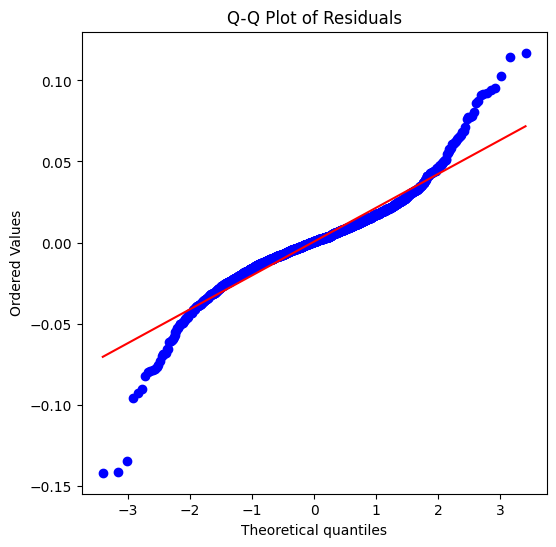

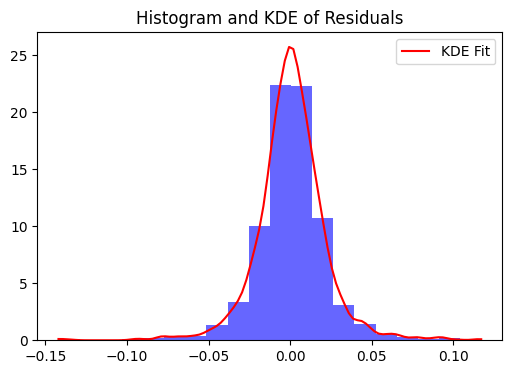

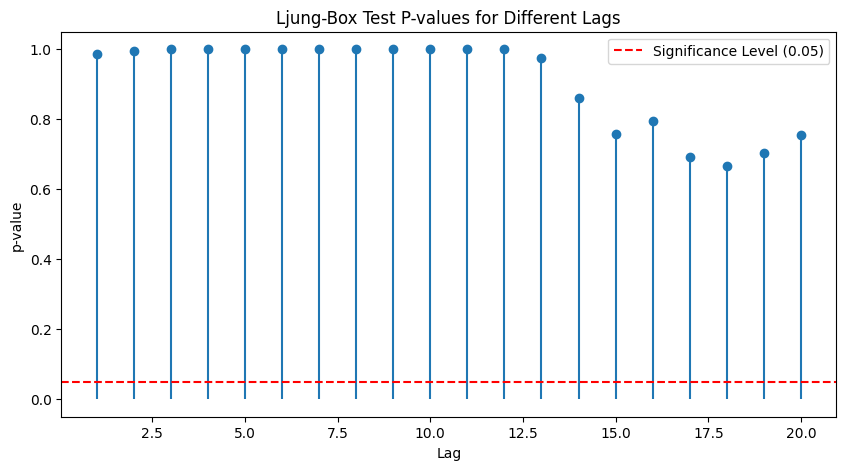

MAE: 0.0149
MSE: 0.0005
RMSE: 0.0216


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


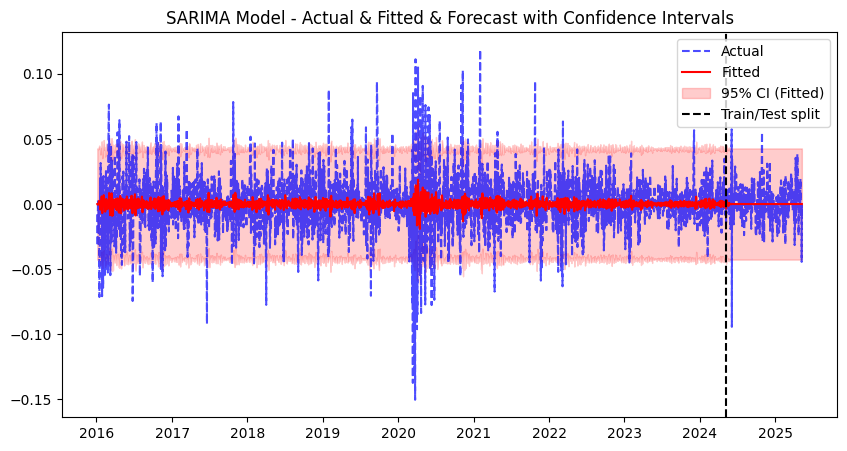

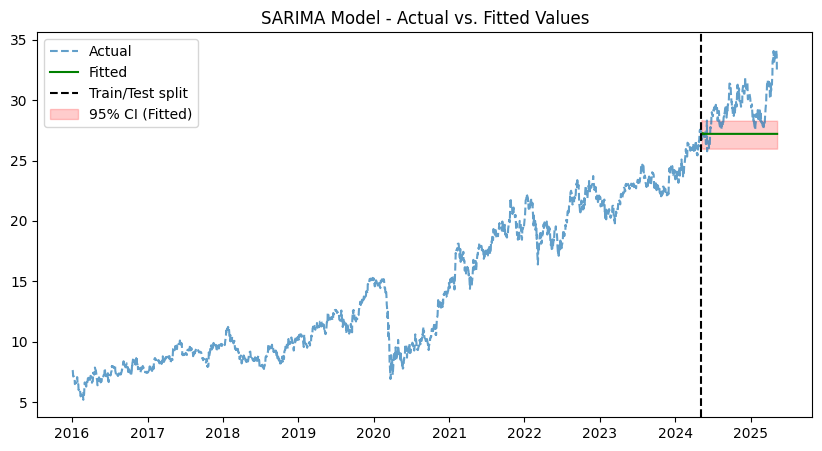

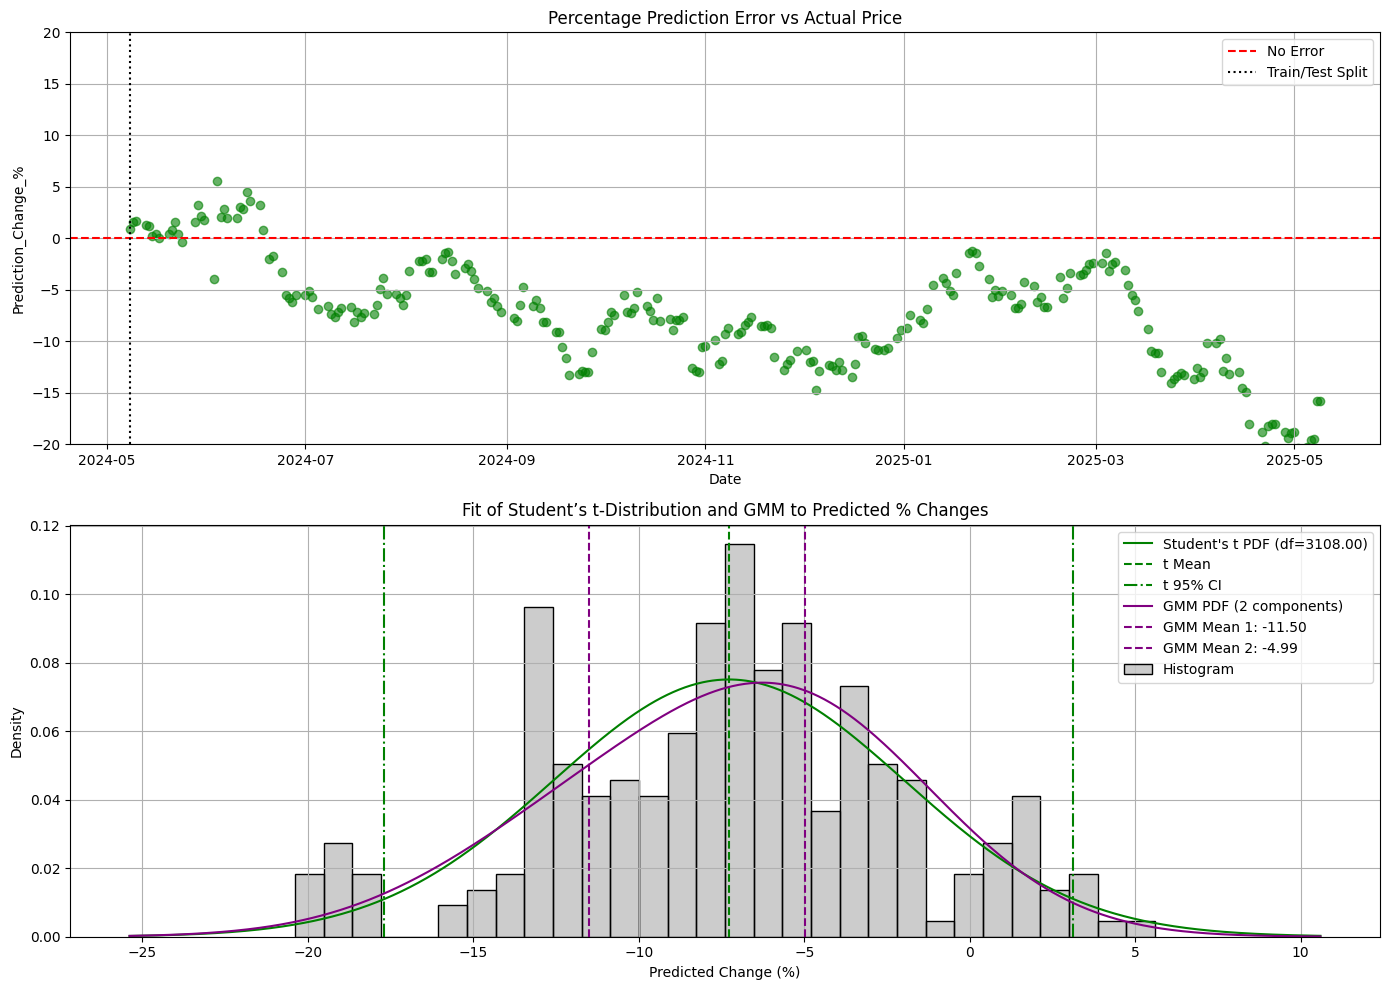

Student's t-distribution 95% CI: [-17.69, 3.13]
GMM means: [-11.50419656  -4.99226608], std devs: [4.44359101 4.23227711]


In [15]:
npast=10  #Memory
predictor.run_ts(order=(npast,0,0), seasonal_order=(1,0,0,12), model_type='SARIMAModel') #Options available - SARIMAModel ,